# Predicting Taxi Ride Duration


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

## The Data
Attributes of all [yellow taxi](https://en.wikipedia.org/wiki/Taxicabs_of_New_York_City) trips in January 2016 are published by the [NYC Taxi and Limosine Commission](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

Columns of the `taxi` table in `taxi.db` include:
- `pickup_datetime`: date and time when the meter was disengaged
- `dropoff_datetime`: date and time when the meter was engaged
- `pickup_lon`: the longitude where the meter was engaged
- `pickup_lat`: the latitude where the meter was engaged
- `dropoff_lon`: the longitude where the meter was disengaged
- `dropoff_lat`: the latitude where the meter was disengaged
- `passengers`: the number of passengers in the vehicle (driver entered value)
- `distance`: trip distance
- `duration`: duration of the trip in seconds

The goal will be to predict `duration` from the pick-up time, pick-up and drop-off locations, and distance.

## Part 1: Data Selection and Cleaning



Use a SQL query to load the `taxi` table from `taxi.db` into a Pandas DataFrame called `all_taxi`. 

Only include trips that have **both** pick-up and drop-off locations within the boundaries of New York City:

- Longitude is between -74.03 and -73.75 (inclusive of both boundaries)
- Latitude is between 40.63 and 40.85 (inclusive of both boundaries)



In [2]:
import sqlite3

conn = sqlite3.connect('taxi.db')
lon_bounds = [-74.03, -73.75]
lat_bounds = [40.6, 40.88]

all_taxi = pd.read_sql_query("""
SELECT * 
FROM taxi
WHERE (pickup_lon BETWEEN -74.03 AND -73.75) AND 
        (pickup_lat BETWEEN 40.6 AND 40.88) AND 
        (dropoff_lon BETWEEN -74.03 AND -73.75) AND 
        (dropoff_lat BETWEEN 40.6 AND 40.88);""", conn)

all_taxi.head()

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,1,3.99,981
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299
3,2016-01-01 04:13:41,2016-01-01 04:19:24,-73.944725,40.714539,-73.955421,40.719173,1,0.80,343
4,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470


A scatter plot of pickup locations shows that most of them are on the island of Manhattan. The empty white rectangle is Central Park; cars are not allowed there.

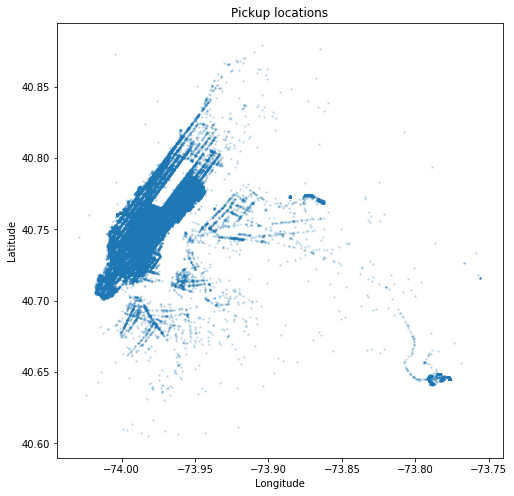

In [3]:
def pickup_scatter(t):
    plt.scatter(t['pickup_lon'], t['pickup_lat'], s=2, alpha=0.2)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Pickup locations')
    
plt.figure(figsize=(8, 8))
pickup_scatter(all_taxi)

The two small blobs outside of Manhattan with very high concentrations of taxi pick-ups are airports.


Create a DataFrame called `clean_taxi` that only includes trips with a positive passenger count, a positive distance, a duration of at least 1 minute and at most 1 hour, and an average speed of at most 100 miles per hour. Inequalities should not be strict (e.g., `<=` instead of `<`) unless comparing to 0.

In [4]:
all_taxi.head()

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,1,3.99,981
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299
3,2016-01-01 04:13:41,2016-01-01 04:19:24,-73.944725,40.714539,-73.955421,40.719173,1,0.80,343
4,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470


In [5]:
clean_taxi = all_taxi[(all_taxi['passengers'] >= 1) & 
                      (all_taxi['distance'] > 0) &
                      (all_taxi['duration'] >= 60) &
                      (all_taxi['duration'] <= 3600) &
                      (((all_taxi['distance']/all_taxi['duration'])*3600) <= 100)
                     ]

In [6]:
manhattan_taxi = pd.read_csv('manhattan_taxi.csv')

A scatter diagram of only Manhattan taxi rides has the familiar shape of Manhattan Island. 

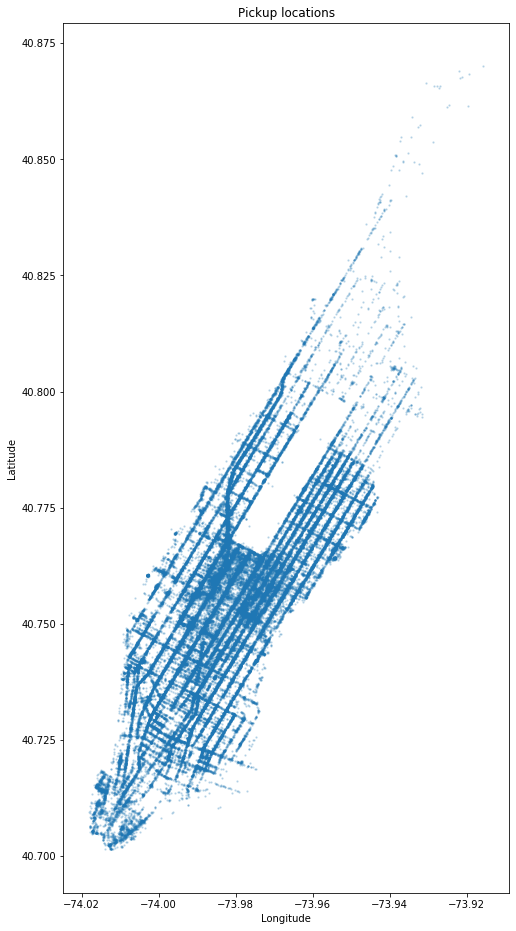

In [7]:
plt.figure(figsize=(8, 16))
pickup_scatter(manhattan_taxi)


Summary of the data selection and cleaning performed. 

In [8]:
print('Initial Number of Trips= {}\n'.format(list(all_taxi.shape)[0]))
print('Number of Trips after deleting trips out of bounds or with incorrect data = {}\n Percentage Loss= {}\n'
      .format(list(clean_taxi.shape)[0],
              np.round((list(all_taxi.shape)[0]-list(clean_taxi.shape)[0])/(list(all_taxi.shape)[0]*0.01),2)))
print('Number of Trips after deleting trips not in Manhattan = {}\n Percentage Loss= {}'
      .format(list(manhattan_taxi.shape)[0],
              np.round((list(all_taxi.shape)[0]-list(manhattan_taxi.shape)[0])/(list(all_taxi.shape)[0]*0.01),2)))


Initial Number of Trips= 97692

Number of Trips after deleting trips out of bounds or with incorrect data = 96445
 Percentage Loss= 1.28

Number of Trips after deleting trips not in Manhattan = 82800
 Percentage Loss= 15.24


## Part 2: Exploratory Data Analysis

In this part, you'll choose which days to include as training data in your regression model. 

January 2016 had some atypical days. New Years Day (January 1) fell on a Friday. MLK Day was on Monday, January 18. A [historic blizzard](https://en.wikipedia.org/wiki/January_2016_United_States_blizzard) passed through New York that month. Using this dataset to train a general regression model for taxi trip times must account for these unusual phenomena, and one way to account for them is to remove atypical days from the training data.

In [9]:
manhattan_taxi.head()

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,2,3.99,981
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299
3,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470
4,2016-01-02 12:39:57,2016-01-02 12:53:29,-73.958214,40.760525,-73.983360,40.760406,1,1.70,812


In [10]:
manhattan_taxi['pickup_datetime'] = pd.to_datetime(manhattan_taxi['pickup_datetime'])
manhattan_taxi['date'] = manhattan_taxi['pickup_datetime'].dt.date

manhattan_taxi.head()

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration,date
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,2,3.99,981,2016-01-30
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320,2016-01-04
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299,2016-01-07
3,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470,2016-01-08
4,2016-01-02 12:39:57,2016-01-02 12:53:29,-73.958214,40.760525,-73.983360,40.760406,1,1.70,812,2016-01-02


Data visualization that allows you to identify which dates were affected by the historic blizzard of January 2016.

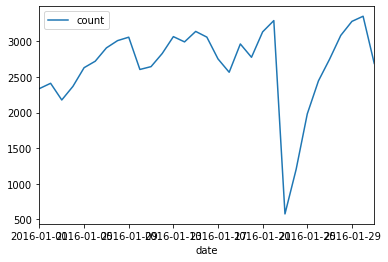

In [11]:
temp = pd.DataFrame(manhattan_taxi['date'].value_counts())
temp['count'] = temp['date']
temp['date'] = temp.index
temp.sort_values(by = 'date', inplace = True)
temp.head()


temp[['date','count']].set_index('date').plot()

Finally, we have generated a list of dates that should have a fairly typical distribution of taxi rides, which excludes holidays and blizzards. The cell below assigns `final_taxi` to the subset of `manhattan_taxi` that is on these days. (No changes are needed; just run this cell.)

In [12]:
import calendar
import re

from datetime import date

atypical = [1, 2, 3, 18, 23, 24, 25, 26]
typical_dates = [date(2016, 1, n) for n in range(1, 32) if n not in atypical]
typical_dates

print('Typical dates:\n')
pat = '  [1-3]|18 | 23| 24|25 |26 '
print(re.sub(pat, '   ', calendar.month(2016, 1)))

final_taxi = manhattan_taxi[manhattan_taxi['date'].isin(typical_dates)]

Typical dates:

    January 2016
Mo Tu We Th Fr Sa Su
                    
 4  5  6  7  8  9 10
11 12 13 14 15 16 17
   19 20 21 22      
      27 28 29 30 31



## Part 3: Feature Engineering

In this part, we'll create a design matrix (i.e., feature matrix) for our linear regression model. We decide to predict trip duration from the following inputs: start location, end location, trip distance, time of day, and day of the week (*Monday, Tuesday, etc.*). 

Because we are going to look at the data in detail in order to define features, it's best to split the data into training and test sets now, then only inspect the training set.

In [13]:
import sklearn.model_selection

train, test = sklearn.model_selection.train_test_split(
    final_taxi, train_size=0.8, test_size=0.2, random_state=42)
print('Train:', train.shape, 'Test:', test.shape)

Train: (53680, 10) Test: (13421, 10)


### Data Visualization


[Text(0, 0, '2016-01-04'),
 Text(0, 0, '2016-01-05'),
 Text(0, 0, '2016-01-06'),
 Text(0, 0, '2016-01-07'),
 Text(0, 0, '2016-01-08'),
 Text(0, 0, '2016-01-09'),
 Text(0, 0, '2016-01-10'),
 Text(0, 0, '2016-01-11'),
 Text(0, 0, '2016-01-12'),
 Text(0, 0, '2016-01-13'),
 Text(0, 0, '2016-01-14'),
 Text(0, 0, '2016-01-15'),
 Text(0, 0, '2016-01-16'),
 Text(0, 0, '2016-01-17'),
 Text(0, 0, '2016-01-19'),
 Text(0, 0, '2016-01-20'),
 Text(0, 0, '2016-01-21'),
 Text(0, 0, '2016-01-22'),
 Text(0, 0, '2016-01-27'),
 Text(0, 0, '2016-01-28'),
 Text(0, 0, '2016-01-29'),
 Text(0, 0, '2016-01-30'),
 Text(0, 0, '2016-01-31')]

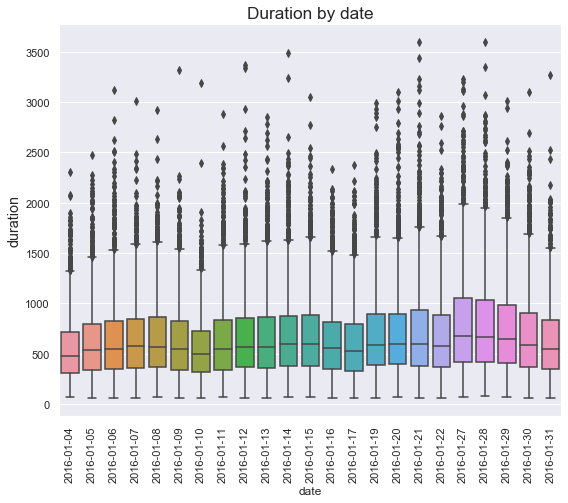

In [14]:
t2 = train.sort_values(by='date')


sns.set(rc={'figure.figsize':(9,7.2)})
ax = sns.boxplot(x='date',y='duration',data = t2)
ax.set_title('Duration by date', size ='x-large')
ax.set_ylabel('duration', size='large')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

On weekends, that is on Saturdays and Sundays, we generally see the duration of rides is a bit less than the weekdays of the same week period. This trend continues for almost all week periods, where when compared within each week, generally the weekends have shorter ride durations that the corresponding weekdays. We also notice mondays having a marginally lower ride duration than that of other weekdays.

Below, the provided `augment` function adds various columns to a taxi ride dataframe. 

- `hour`: The integer hour of the pickup time. E.g., a 3:45pm taxi ride would have `15` as the hour. A 12:20am ride would have `0`.
- `day`: The day of the week with Monday=0, Sunday=6.
- `weekend`: 1 if and only if the `day` is Saturday or Sunday.
- `period`: 1 for early morning (12am-6am), 2 for daytime (6am-6pm), and 3 for night (6pm-12pm).
- `speed`: Average speed in miles per hour.


In [15]:
def speed(t):
    """Return a column of speeds in miles per hour."""
    return t['distance'] / t['duration'] * 60 * 60

def augment(t):
    """Augment a dataframe t with additional columns."""
    u = t.copy()
    pickup_time = pd.to_datetime(t['pickup_datetime'])
    u.loc[:, 'hour'] = pickup_time.dt.hour
    u.loc[:, 'day'] = pickup_time.dt.weekday
    u.loc[:, 'weekend'] = (pickup_time.dt.weekday >= 5).astype(int)
    u.loc[:, 'period'] = np.digitize(pickup_time.dt.hour, [0, 6, 18])
    u.loc[:, 'speed'] = speed(t)
    return u
    
train = augment(train)
test = augment(test)
train.iloc[0,:] # An example row

pickup_datetime     2016-01-21 18:02:20
dropoff_datetime    2016-01-21 18:27:54
pickup_lon                     -73.9942
pickup_lat                       40.751
dropoff_lon                    -73.9637
dropoff_lat                     40.7711
passengers                            1
distance                           2.77
duration                           1534
date                         2016-01-21
hour                                 18
day                                   3
weekend                               0
period                                3
speed                           6.50065
Name: 14043, dtype: object

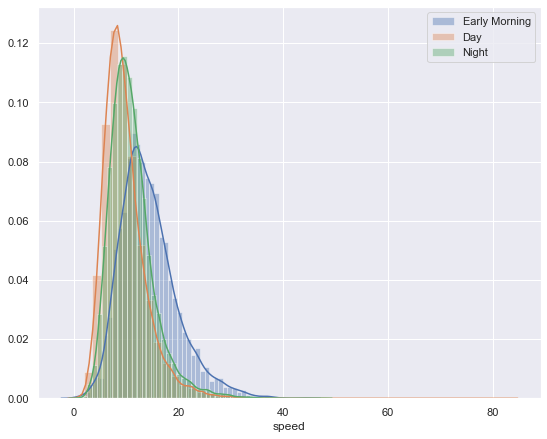

In [16]:
Early_Morning = train[train['hour'] < 6]
Day = train[(train['hour'] >= 6) & (train['hour'] < 19)]
Night = train[train['hour'] >= 18]


sns.distplot(Early_Morning['speed'], label = 'Early Morning', hist = True)
sns.distplot(Day['speed'], label = 'Day', hist = True)
sns.distplot(Night['speed'],label = 'Night', hist = True)
plt.legend()

It looks like the time of day is associated with the average speed of a taxi ride.


Manhattan can roughly be divided into Lower, Midtown, and Upper regions. Instead of studying a map, let's approximate by finding the first principal component of the pick-up location (latitude and longitude). 


In [17]:
# Find the first principle component
D = train[['pickup_lat','pickup_lon']].values
pca_n = D.shape[0]
pca_means = np.mean(D, axis=0)
X = (D - pca_means) / np.sqrt(pca_n)
u, s, vt = np.linalg.svd(X, full_matrices=False)

def add_region(t):
    """Add a region column to t based on vt above."""
    D = t[['pickup_lat','pickup_lon']].values
    assert D.shape[0] == t.shape[0], 'You set D using the incorrect table'
    # Always use the same data transformation used to compute vt
    X = (D - pca_means) / np.sqrt(pca_n) 
    first_pc = (X @ vt.T)[:, 0]
    t.loc[:,'region'] = pd.qcut(first_pc, 3, labels=[0, 1, 2])
    
add_region(train)
add_region(test)

Let's see how PCA divided the trips into three groups. These regions do roughly correspond to Lower Manhattan (below 14th street), Midtown Manhattan (between 14th and the park), and Upper Manhattan (bordering Central Park). No prior knowledge of New York geography was required!

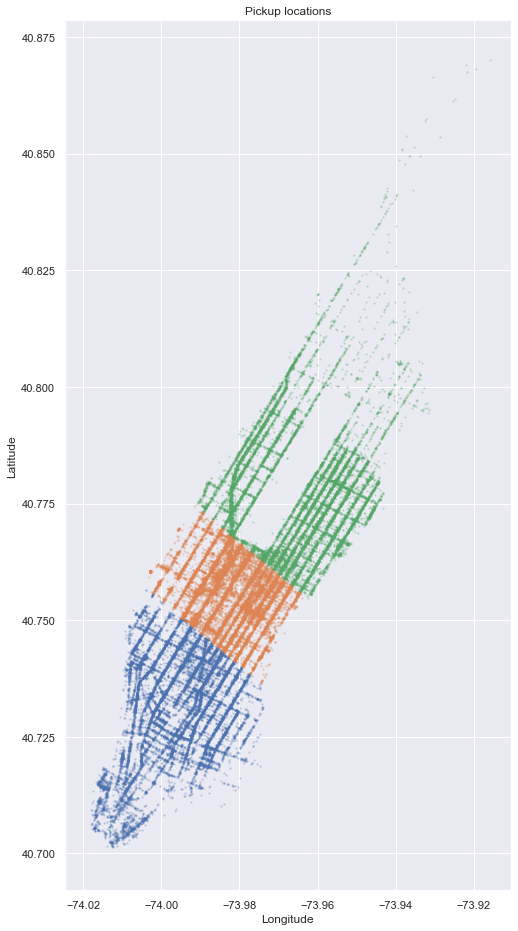

In [18]:
plt.figure(figsize=(8, 16))
for i in [0, 1, 2]:
    pickup_scatter(train[train['region'] == i])

Finally, we create a design matrix that includes many of these features. Quantitative features are converted to standard units, while categorical features are converted to dummy variables using one-hot encoding. The `period` is not included because it is a linear combination of the `hour`. The `weekend` variable is not included because it is a linear combination of the `day`.  The `speed` is not included because it was computed from the `duration`; it's impossible to know the speed without knowing the duration, given that you know the distance.

In [19]:
from sklearn.preprocessing import StandardScaler

num_vars = ['pickup_lon', 'pickup_lat', 'dropoff_lon', 'dropoff_lat', 'distance']
cat_vars = ['hour', 'day', 'region']

scaler = StandardScaler()
scaler.fit(train[num_vars])

def design_matrix(t):
    """Create a design matrix from taxi ride dataframe t."""
    scaled = t[num_vars].copy()
    scaled.iloc[:,:] = scaler.transform(scaled) # Convert to standard units
    categoricals = [pd.get_dummies(t[s], prefix=s, drop_first=True) for s in cat_vars]
    return pd.concat([scaled] + categoricals, axis=1)

design_matrix(train).iloc[0,:]  

pickup_lon    -0.805821
pickup_lat    -0.171761
dropoff_lon    0.954062
dropoff_lat    0.624203
distance       0.626326
hour_1         0.000000
hour_2         0.000000
hour_3         0.000000
hour_4         0.000000
hour_5         0.000000
hour_6         0.000000
hour_7         0.000000
hour_8         0.000000
hour_9         0.000000
hour_10        0.000000
hour_11        0.000000
hour_12        0.000000
hour_13        0.000000
hour_14        0.000000
hour_15        0.000000
hour_16        0.000000
hour_17        0.000000
hour_18        1.000000
hour_19        0.000000
hour_20        0.000000
hour_21        0.000000
hour_22        0.000000
hour_23        0.000000
day_1          0.000000
day_2          0.000000
day_3          1.000000
day_4          0.000000
day_5          0.000000
day_6          0.000000
region_1       1.000000
region_2       0.000000
Name: 14043, dtype: float64

## Part 4: Model Selection

In this part, you will select a regression model to predict the duration of a taxi ride.



In [20]:
def rmse(errors):
    """Return the root mean squared error."""
    return np.sqrt(np.mean(errors ** 2))

mean_train = train['duration'].mean()
error = test['duration'] - mean_train
constant_rmse = rmse(error)
constant_rmse

399.1437572352677

In [21]:
X_train = train[['distance']]
y_train = train[['duration']]

X_test = test[['distance']]
y_test = test[['duration']]

In [22]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

simple_rmse = rmse(y_pred - y_test).values[0]
simple_rmse

276.7841105000337

In [23]:
model = LinearRegression()

X_train = train[['pickup_lon', 
                 'pickup_lat',
                 'dropoff_lon', 
                 'dropoff_lat',
                 'distance', 
                 'hour', 
                 'day', 
                 'region']]

y_train = train[['duration']]

X_test = test[['pickup_lon', 
                 'pickup_lat',
                 'dropoff_lon', 
                 'dropoff_lat',
                 'distance', 
                 'hour', 
                 'day', 
                 'region']]

y_test = test[['duration']]

model.fit(design_matrix(X_train),y_train)

y_pred = model.predict(design_matrix(X_test))


linear_rmse = rmse(y_pred-y_test).values[0]
linear_rmse

255.1914663188278


For each possible value of `period`, fit an unregularized linear regression model to the subset of the training set in that `period`.   Again, fit to the training set and use the `design_matrix` function for features.



In [24]:
train.head()

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration,date,hour,day,weekend,period,speed,region
14043,2016-01-21 18:02:20,2016-01-21 18:27:54,-73.994202,40.751019,-73.963692,40.771069,1,2.77,1534,2016-01-21,18,3,0,3,6.500652,1
9122,2016-01-29 06:18:36,2016-01-29 06:21:32,-73.990402,40.756344,-73.984161,40.761757,3,0.69,176,2016-01-29,6,4,0,2,14.113636,1
9291,2016-01-04 20:34:21,2016-01-04 20:42:33,-74.006554,40.732922,-74.001175,40.751366,1,1.60,492,2016-01-04,20,0,0,3,11.707317,0
76214,2016-01-09 12:12:58,2016-01-09 12:20:26,-73.992065,40.750313,-73.982803,40.755829,1,0.90,448,2016-01-09,12,5,1,2,7.232143,1
46314,2016-01-13 10:57:45,2016-01-13 11:02:06,-73.959358,40.771824,-73.964661,40.770443,1,0.40,261,2016-01-13,10,2,0,2,5.517241,2


In [25]:
model = LinearRegression()
errors = []

for v in np.unique(train['period']):
    X_train = train[train['period'] == v][['pickup_lon', 
                                   'pickup_lat',
                                   'dropoff_lon', 
                                   'dropoff_lat',
                                   'distance',
                                   'hour',
                                   'day',
                                   'region']]
    
    y_train = train[train['period'] == v][['duration']]

    X_test = test[test['period'] == v][['pickup_lon', 
                                      'pickup_lat',
                                      'dropoff_lon', 
                                      'dropoff_lat',
                                      'distance', 
                                      'hour', 
                                      'day', 
                                      'region']]
    
    y_test = test[test['period'] == v][['duration']]

    model = LinearRegression()
    model.fit(design_matrix(X_train),y_train)
    y_pred = model.predict(design_matrix(X_test))

    errors=errors+list(pd.DataFrame(y_pred-y_test)['duration'])
    
period_rmse = rmse(np.array(errors))
period_rmse

246.62868831165173

This approach is a simple form of decision tree regression, where a different regression function is estimated for each possible choice among a collection of choices. In this case, the depth of the tree is only 1.

In the period regression model, each model is being trained to perform well according to that particular period. In a model which is trained on all periods simulataneously, the weights will be distributed between all period values. This causes the period regression model to be better suited to each period indiviually and hence overall outperforms the former model.


Instead of predicting duration directly, an alternative is to predict the average *speed* of the taxi ride using linear regression, then compute an estimate of the duration from the predicted speed and observed distance for each ride.

In [26]:
train.head()

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration,date,hour,day,weekend,period,speed,region
14043,2016-01-21 18:02:20,2016-01-21 18:27:54,-73.994202,40.751019,-73.963692,40.771069,1,2.77,1534,2016-01-21,18,3,0,3,6.500652,1
9122,2016-01-29 06:18:36,2016-01-29 06:21:32,-73.990402,40.756344,-73.984161,40.761757,3,0.69,176,2016-01-29,6,4,0,2,14.113636,1
9291,2016-01-04 20:34:21,2016-01-04 20:42:33,-74.006554,40.732922,-74.001175,40.751366,1,1.60,492,2016-01-04,20,0,0,3,11.707317,0
76214,2016-01-09 12:12:58,2016-01-09 12:20:26,-73.992065,40.750313,-73.982803,40.755829,1,0.90,448,2016-01-09,12,5,1,2,7.232143,1
46314,2016-01-13 10:57:45,2016-01-13 11:02:06,-73.959358,40.771824,-73.964661,40.770443,1,0.40,261,2016-01-13,10,2,0,2,5.517241,2


In [27]:
model = LinearRegression()

X_train = train[['pickup_lon', 
                 'pickup_lat',
                 'dropoff_lon', 
                 'dropoff_lat',
                 'distance', 
                 'hour', 
                 'day', 
                 'region']]

y_train = train[['speed']]

X_test = test[['pickup_lon', 
                 'pickup_lat',
                 'dropoff_lon', 
                 'dropoff_lat',
                 'distance', 
                 'hour', 
                 'day', 
                 'region']]

y_test = test[['speed']]

model.fit(design_matrix(X_train),y_train)

y_pred = model.predict(design_matrix(X_test))

In [28]:
y_pred

array([[11.0748834 ],
       [ 8.78879337],
       [ 8.31341586],
       ...,
       [ 8.33736294],
       [10.3118391 ],
       [10.66421556]])

In [29]:
a = np.array(test['distance'])
a

array([3.04, 2.  , 0.6 , ..., 1.04, 2.3 , 1.7 ])

In [30]:
duration = (a / y_pred) * 3600

In [31]:
speed_rmse = rmse(duration-y_test).values[0]
speed_rmse

ValueError: Unable to coerce to DataFrame, shape must be (13421, 1): given (13421, 13421)

In [32]:
X=train[['pickup_lon', 'pickup_lat','dropoff_lon', 'dropoff_lat',  
         'distance', 'hour', 'day', 'region']]
Y=train[['speed']]

X_test=test[['pickup_lon', 'pickup_lat','dropoff_lon', 'dropoff_lat',  
         'distance', 'hour', 'day', 'region']]

model = LinearRegression()
model.fit(design_matrix(X),Y)

X_2= pd.DataFrame(train[['distance']])
X_2['pred_speed']=model.predict(design_matrix(X))
Y_2=train['duration']



X_test_2=pd.DataFrame(test[['distance']])
X_test_2['pred_speed']=model.predict(design_matrix(X_test))
Y_test=test['duration']

model.fit(np.array(X_2),Y_2)
pred_test=model.predict(np.array(X_test_2))

speed_rmse = rmse(Y_test-pred_test)
speed_rmse

256.1152287872432


Finally, complete the function `tree_regression_errors` (and helper function `speed_error`) that combines the ideas from the two previous models and generalizes to multiple categorical variables.

The `tree_regression_errors` should:
- Find a different linear regression model for each possible combination of the variables in `choices`;
- Fit to the specified `outcome` (on train) and predict that `outcome` (on test) for each combination (`outcome` will be `'duration'` or `'speed'`);
- Use the specified `error_fn` (either `duration_error` or `speed_error`) to compute the error in predicted duration using the predicted outcome;
- Aggregate those errors over the whole test set and return them.



In [33]:
model = LinearRegression()
choices = ['period', 'region', 'weekend']

def duration_error(predictions, observations):
    """Error between predictions (array) and observations (data frame)"""
    return predictions - observations['duration']

def speed_error(predictions, observations):
    """Duration error between speed predictions and duration observations"""
    predictions_duration = (observations['distance'] * 3600) / predictions
    return predictions_duration - observations['duration']

def tree_regression_errors(outcome='duration', error_fn=duration_error):
    """Return errors for all examples in test using a tree regression model."""
    
    errors = []
    
    for vs in train.groupby(choices).size().index:
        v_train, v_test = train, test
        for v, c in zip(vs, choices):
            v_train = v_train.loc[ v_train[c] == v, :]
            v_test = v_test.loc[ v_test[c] == v, :]
    
        design_train = design_matrix(v_train)
        design_test = design_matrix(v_test)
        
        X_train = design_train
        Y_train = v_train.loc[ : , outcome ]
        X_test = design_test
        Y_test = v_test.loc[ : , outcome ]
        
        model.fit(X_train, Y_train)
        predictions = np.array(model.predict(X_test))

        eps = error_fn(predictions,v_test).tolist()
    
        errors = errors + eps
            
    return errors

errors = tree_regression_errors()
errors_via_speed = tree_regression_errors('speed', speed_error)

tree_rmse = rmse(np.array(errors))
tree_speed_rmse = rmse(np.array(errors_via_speed))

print('Duration:', tree_rmse, '\nSpeed:', tree_speed_rmse)

Duration: 240.33952192703526 
Speed: 226.90793945018308


Here's a summary of your results:

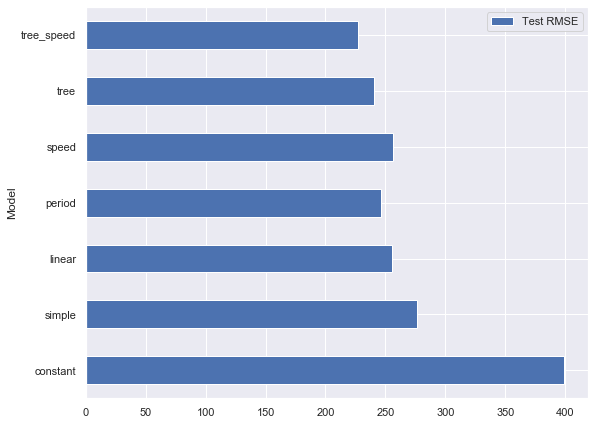

In [34]:
models = ['constant', 'simple', 'linear', 'period', 'speed', 'tree', 'tree_speed']
pd.DataFrame.from_dict({
    'Model': models,
    'Test RMSE': [eval(m + '_rmse') for m in models]
}).set_index('Model').plot(kind='barh');

## Future Work

Here are some questions to ponder:

- The regression model would have been more accurate if we had used the date itself as a feature instead of just the day of the week. Why didn't we do that?
- Does collecting this information about every taxi ride introduce a privacy risk? The original data also included the total fare; how could someone use this information combined with an individual's credit card records to determine their location?
- Why did we treat `hour` as a categorical variable instead of a quantitative variable? Would a similar treatment be beneficial for latitude and longitude?
- Why are Google Maps estimates of ride time much more accurate than our estimates?


Here are some possible extensions to the project:

- An alternative to throwing out atypical days is to condition on a feature that makes them atypical, such as the weather or holiday calendar. How would you do that?
- Training a different linear regression model for every possible combination of categorical variables can overfit. How would you select which variables to include in a decision tree instead of just using them all?
- Your models use the observed distance as an input, but the distance is only observed after the ride is over. How could you estimate the distance from the pick-up and drop-off locations?
- How would you incorporate traffic data into the model?